# Time Series Transformer on Synthetic Function Data

This script trains a Time Series Transformer on a synthetic dataset where each time series is generated as as a function of t


In [6]:
# Imports

!pip install -q transformers datasets evaluate accelerate gluonts ujson
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from functools import lru_cache, partial

# Hugging Face Transformers for time series
from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
)

# GluonTS imports for time features and transforms
from gluonts.time_feature import time_features_from_frequency_str, get_lags_for_frequency
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    Chain,
    RemoveFields,
    AsNumpyArray,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AddAgeFeature,
    VstackFeatures,
    RenameFields,
    InstanceSplitter,
)
from gluonts.transform.sampler import ExpectedNumInstanceSampler, TestSplitSampler

# Just in case
from datasets import Dataset

print("Imports complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

## Dataset Generation - we define our function here

In [7]:
# Generate training and validation data

# ----- Parameters -----
num_series = 200         # Number of time series (fragments) to simulate
prediction_length = 50  # Forecast horizon: number of time steps to predict
train_length = 250      # Number of time steps used for training (historical data)
total_length = train_length + prediction_length  # Total length of each series

# Define a base date for the start of the time series
base_date = pd.to_datetime("2020-01-01")

# Lists to store the datasets
train_dataset = []
validation_dataset = []

# Generate multiple time series fragments from the same function
for i in range(num_series):
    # Each series gets a different start date (e.g., day i)
    start_date = base_date + pd.Timedelta(days=i)
    start = pd.Period(start_date, freq="D")  # Using daily frequency for simplicity

    # Create a time vector for this series
    t_vals = np.arange(total_length)  # 0, 1, 2, ..., total_length-1

    '''
    This is the function we predict!! Input it here
    Ex. values = np.exp(-t_vals)
    '''
    values = np.exp(-t_vals)


    # Training series: use only the historical part (first train_length points)
    train_series = {
        "start": start,
        "target": values[:train_length].tolist(),
    }

    # Validation series: use the full series (historical data + forecast horizon)
    # The last 'prediction_length' points serve as the ground truth for evaluation.
    full_series = {
        "start": start,
        "target": values.tolist(),
    }

    train_dataset.append(train_series)
    validation_dataset.append(full_series)

# Quick summary
print("Number of training series:", len(train_dataset))
print("Length of each training series:", len(train_dataset[0]["target"]))
print("Number of validation series:", len(validation_dataset))
print("Length of each validation series:", len(validation_dataset[0]["target"]))


Number of training series: 200
Length of each training series: 250
Number of validation series: 200
Length of each validation series: 300


In [8]:
# Assert the validation dataset is the length of the training dataset + prediction length
for idx in range(num_series):
  assert len((train_dataset[idx]['target'])) + prediction_length == len(validation_dataset[idx]['target'])

Index: 55
Starting time: 2020-02-25


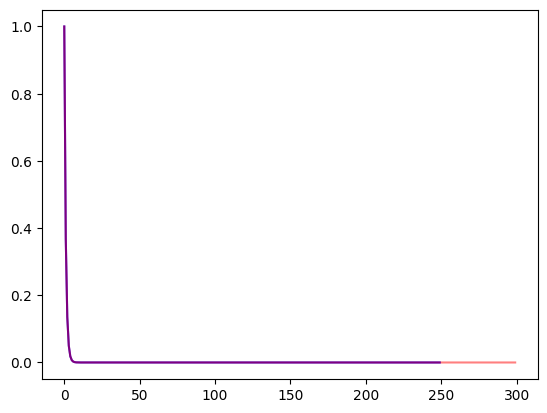

In [9]:
# Plot a dataset, alongside its corresponding validation dataset

import matplotlib.pyplot as plt

idx = int(input("Index: "))

figure, axes = plt.subplots()
print(f"Starting time: {train_dataset[idx]['start']}")
axes.plot(train_dataset[idx]["target"], color="blue")
axes.plot(validation_dataset[idx]["target"], color="red", alpha=0.5)

plt.show()

In [10]:
# Create our training and test split

import random

# Shuffle the dataset to randomize the order of time series
random.shuffle(train_dataset)

# Then split into train and test
train_split = train_dataset[:100]
test_split = train_dataset[100:200]

# Assign series id
for i in range(len(train_split)):
  train_split[i]['feat_static_cat'] = [i]
  test_split[i]['feat_static_cat'] = [i]


In [11]:
# Gather additional features (lag/time) - time may not be necessary for function extrapolation (but may be helpful to have regardless!)

import pandas as pd
from gluonts.time_feature import get_lags_for_frequency, time_features_from_frequency_str

# Define the frequency as daily ("D")
freq = "D"

# Generate the lags sequence for daily data.
# This will automatically choose appropriate lags (e.g., 1 day, 7 days, etc.).
lags_sequence = get_lags_for_frequency(freq)
print("Lags sequence for daily frequency:", lags_sequence)

# Generate time features for daily frequency.
# Typical features include "day of week", "day of month", etc.
time_features = time_features_from_frequency_str(freq)
print("Time features for daily frequency:", time_features)


Lags sequence for daily frequency: [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]
Time features for daily frequency: [<function day_of_week at 0x7daac43c85e0>, <function day_of_month at 0x7daac43c8720>, <function day_of_year at 0x7daac43c8860>]


## Model Instantiation

In [12]:
# Configure our model

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

# Assumptions:
# - 'lags_sequence' has been computed in a previous cell using get_lags_for_frequency("D")
# - We have a prediction horizon of 50 time steps and a context window of 100 time steps.
# - We include a static categorical feature (e.g., series id) for our training set of 100 series.

prediction_length = 50
context_length = prediction_length * 2  # e.g., 100 time steps

# Add in our time features
num_time_features = 4

# We include one static categorical feature (the series id). In our training split we have 100 series.
num_static_categorical_features = 1
cardinality = [100]           # 100 unique series ids in our training split.
embedding_dimension = [3]     # Example embedding size for the static categorical feature.

# Create the configuration.
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,
    lags_sequence=lags_sequence,  # Previously computed for daily frequency
    num_time_features=num_time_features,
    num_static_categorical_features=num_static_categorical_features,
    cardinality=cardinality,
    embedding_dimension=embedding_dimension,
    encoder_layers=2,    # You can adjust this as needed.
    decoder_layers=2,    # You can adjust this as needed.
    d_model=32,          # The hidden dimension size.
)

# Instantiate the model using the configuration.
model = TimeSeriesTransformerForPrediction(config)
print("Model configured with:")
print(config)


Model configured with:
TimeSeriesTransformerConfig {
  "_attn_implementation_autoset": true,
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "cardinality": [
    100
  ],
  "context_length": 100,
  "d_model": 32,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    3
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 39,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    13,
    14,
    15,
    20,
    21,
    22,
    27,
    28,
    29,
    30,
    31,
    56,
    84,
    363,
    364,
    365,
    727,
    728,
    729,
    1091,
    1092,
    1093
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynami

In [13]:
# Distribution output of our model is student t
model.config.distribution_output

'student_t'

In [14]:
# Define our transformations (in accordance w/ HuggingFace implementation)
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [15]:
# Transformations

from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [16]:
# Instance Splitter

from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [17]:
# Create DataLoaders

from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the multiple possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )



In [18]:
# Backtest dataloader

def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # We create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [19]:
# HuggingFace default settings

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_split,  # use the split subset
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_split,   # use the split subset
    batch_size=64,
)


In [20]:
# Batch check

batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 1193, 4]) torch.FloatTensor
past_values torch.Size([256, 1193]) torch.FloatTensor
past_observed_mask torch.Size([256, 1193]) torch.FloatTensor
future_time_features torch.Size([256, 50, 4]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.LongTensor
future_values torch.Size([256, 50]) torch.FloatTensor
future_observed_mask torch.Size([256, 50]) torch.FloatTensor


In [21]:
time_features = time_features_from_frequency_str("D")
print("Number of time features from frequency:", len(time_features))


Number of time features from frequency: 3


In [22]:
# Singular forward pass

outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

print("Loss:", outputs.loss.item())

Loss: -11.861154556274414


## Train our model

In [23]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

-11.31205940246582
-11.837017059326172
-13.384695053100586
-13.87793254852295
-14.047611236572266
-13.947809219360352
-13.08434772491455
-14.31692123413086
-14.89931869506836
-14.332098007202148
-14.309226036071777
-15.266388893127441
-14.746110916137695
-15.214975357055664
-15.53933334350586
-15.06649398803711
-15.434723854064941
-15.164606094360352


KeyboardInterrupt: 

## Model Inference

In [ ]:
# Gather forecasts

model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts[0].shape

In [ ]:
# Stack

forecasts = np.vstack(forecasts)
print(forecasts.shape)

In [ ]:
# Evaluate against ground-truth

from evaluate import load
from gluonts.time_feature import get_seasonality

# Load metrics
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

# Compute the median forecast for each series from our forecasts.
# forecasts shape: (num_series_in_test, num_samples, prediction_length)
forecast_median = np.median(forecasts, axis=1)

mase_metrics = []
smape_metrics = []
# Here, we iterate over each time series in our test split.
# Note: Our test_split (or validation_dataset) should contain the full series, so that
# the last `prediction_length` points are the ground-truth.
for item_id, ts in enumerate(test_split):
    training_data = np.array(ts["target"][:-prediction_length])
    ground_truth = np.array(ts["target"][-prediction_length:])

    # Compute MASE metric
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=ground_truth,
        training=training_data,
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    # Compute sMAPE metric
    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=ground_truth,
    )
    smape_metrics.append(smape["smape"])

print("Average MASE:", np.mean(mase_metrics))
print("Average sMAPE:", np.mean(smape_metrics))


In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [ ]:
# Plot our inference against ground truth data

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_full(ts_index):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Create a timestamp index for the entire series using the start time from test_split.
    index = pd.period_range(
        start=test_split[ts_index]["start"].to_timestamp(),
        periods=len(test_split[ts_index]["target"]),
        freq=freq,
    ).to_timestamp()

    # Plot the full actual series
    ax.plot(index, test_split[ts_index]["target"], label="Actual", color="blue")

    # Extract forecasts for this series.
    # forecasts is assumed to be a stacked array with shape (num_test_series, num_samples, prediction_length)
    forecast = forecasts[ts_index]  # shape: (num_samples, prediction_length)
    median_forecast = np.median(forecast, axis=0)
    forecast_mean = forecast.mean(axis=0)
    forecast_std = forecast.std(axis=0)

    # Overlay the forecast on the last 'prediction_length' points.
    forecast_index = index[-prediction_length:]
    ax.plot(forecast_index, median_forecast, label="Median Forecast", color="orange")
    ax.fill_between(forecast_index,
                    forecast_mean - forecast_std,
                    forecast_mean + forecast_std,
                    color="orange",
                    alpha=0.3,
                    label="±1 std")

    # Set up the x-axis with appropriate date formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.set_title(f"Full Series: Actual and Forecast (Series {ts_index})")
    ax.legend()
    plt.show()

# Usage: plot the full series for a chosen test series index.
plot_full(int(input("Index to plot: ")))
